In [2]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import hstack
import os
import seaborn as sns
from scipy.stats import binned_statistic
import matplotlib
import matplotlib.backends.backend_pdf
from scipy.stats import chi2, binned_statistic
from cosmic_calc import * 

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [3]:
dev_path = '/Users/lejay/research/lephare_dev/my_code/'
output_dir = dev_path+'output_cats/'
graham_output_dir = dev_path + 'graham_output_cats/'

#### write sf/q info and load catalog

In [4]:
def gv_boundary_2(color1, ic_1, ic_2, slope):
    nuv_1 = ic_1
    nuv_2 = slope*color1 + ic_2
    return np.maximum(nuv_1, nuv_2)

In [301]:
diagram_type = 'NUVrK'
phot_type=2 # 0=optical 1=w/nir 2=w/irac 3=full 
best_boxes_nuvrk = np.load('best_select_box_onemassbin_lepharecheck_'+diagram_type+'_.npy')
    
for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
    sfq_nuvrk = []
    cat_output_no_nir_mass_name = graham_output_dir+cat_name+'_cat_out_nomaglimit_nonir_il_22.4_formass.fits'
    cat = Table.read(cat_output_no_nir_mass_name)
    for i in tqdm(range(len(cat))):
        gal = cat[i]
        if abs(gal['MAG_ABS_r']) < 99. and abs(gal['MAG_ABS_Ks'])< 99. and gal['MAG_ABS_NUV']< 99. and abs(gal['MAG_ABS_r'])< 99.:
            rk = gal['MAG_ABS_r'] - gal['MAG_ABS_Ks']
            nuvr = gal['MAG_ABS_NUV'] - gal['MAG_ABS_r']
            if gal['Z_ML']>0 and gal['Z_ML']<1.5:
                delta_gv_nuvrk = nuvr - gv_boundary_2(rk,best_boxes_nuvrk[phot_type][0],best_boxes_nuvrk[phot_type][1],best_boxes_nuvrk[phot_type][2])
                if delta_gv_nuvrk<0:
                    sfq_nuvrk.append(1.)
                else:
                    sfq_nuvrk.append(0.)
            else:
                sfq_nuvrk.append(-99.)
        else:
            sfq_nuvrk.append(99.)
        
    sfq_col_nuvrk = Column(name='sfq_nuvrk_myrun',data=sfq_nuvrk)  # 1=sf, 0=q
    if 'sfq_nuvrk_myrun' in cat.keys():
        cat.remove_column('sfq_nuvrk_myrun')
    cat.add_column(sfq_col_nuvrk)
    cat.write(cat_output_no_nir_mass_name.replace('.fits','_sfq_added.fits'),overwrite=True)
    

100%|██████████| 900000/900000 [05:12<00:00, 2883.00it/s]


In [16]:
cat_output_no_nir_mass_name = graham_output_dir+'cat_out_300k_nonir_il_formass.fits'
cat = Table.read(cat_output_no_nir_mass_name.replace('.fits','_sfq_added.fits'))
arr,ind = np.unique(cat['STRING_INPUT'],return_index=True)
cat = cat[ind]

#### completeness esitmation

In [6]:
from scipy.optimize import curve_fit
def sigmoid(x,a,b):
    return 1/(1+np.exp(-(x+b)/a+1))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

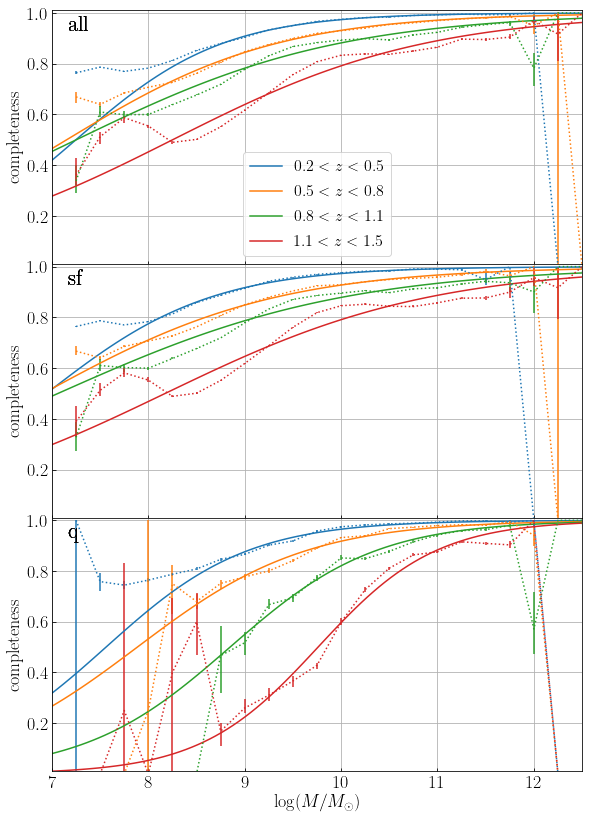

In [25]:
bin_edges = np.linspace(7, 13, num=25)
bin_centers = np.diff(bin_edges) + bin_edges[:-1]
comp_sigmoid_params = Table(names=['z','sfq','a','b'],dtype=['f8','a4','f8','f8'])
inside_j=True

zmins = [0.2,0.5,0.8,1.1]
zmaxs = [0.5,0.8,1.1,1.5]
# zmins = [0.3,0.5,0.7,0.9]
# zmaxs = [0.5,0.7,0.9,1.1]
fig, axs = plt.subplots(3, 1, figsize=(9.5,14),sharex=True, sharey=True)
for i,sfq in enumerate(['all','sf','q']):
    for k,z in enumerate(zmins):
        
        filename = 'completeness_curve_mag/curves/comp_bootstrap_nomaglimit_mass_sfq_nuvrk_myrun_'+sfq+'_'+str(zmins[k])+'_'+str(zmaxs[k])+'.txt'
        curves_mass = np.genfromtxt(filename)
        comp_all = np.median(curves_mass, axis=0)
        comp_all_l = np.percentile(curves_mass,16, axis=0)    
        comp_all_h = np.percentile(curves_mass,84, axis=0)
        if sfq == 'q':
            for j in range(len(comp_all)):
                if j<len(comp_all)/2 and np.isnan(comp_all[j]):
                    comp_all[j]=0
                elif j>len(comp_all)/2 and np.isnan(comp_all[j]):
                    comp_all[j]=1
        else:
            comp_all[np.isnan(comp_all)]=1
        
        # plot data
        axs[i].errorbar(bin_centers,comp_all,yerr=[comp_all-comp_all_l,comp_all_h-comp_all],fmt=colors[k],linestyle=':')
        
        # fitting (modified) sigmoid function to the curves
        popt, pcov = curve_fit(sigmoid, bin_centers[6:-5], comp_all[6:-5],maxfev = 1000)   
        comp_sigmoid_params.add_row([round(z,1),sfq,popt[0],popt[1]])
    
        # plot the sigmoid fit
        x_plot = np.linspace(7,13,100)
        y_plot = sigmoid(x_plot,popt[0],popt[1])
        axs[i].plot(x_plot,y_plot,label=r'$'+str(zmins[k])+'<z<'+str(zmaxs[k])+'$')
    
        axs[i].annotate(sfq,xy=([0.03,0.92]),xycoords='axes fraction',fontsize=22)
        axs[i].set_ylabel('completeness',fontsize=18)
        axs[0].legend(fontsize=16)
        axs[i].set_xlim([7,12.5])
    axs[i].grid()
        
plt.ylim([0.01,1.01])
plt.xlabel(r'$\log(M/M_\odot)$',fontsize=18)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

comp_sigmoid_params.write('comp_sigmoid_params.fits',overwrite=True)

#### mass vs z
use overall catalog

(6.8, 12.6)

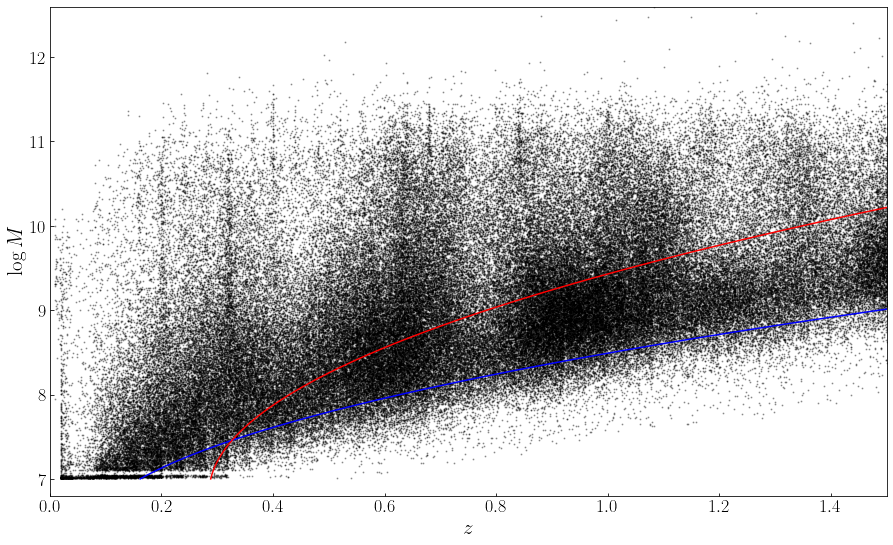

In [38]:
cat = Table.read('/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_300k_nonir_il_formass.fits')

# z_edges = np.linspace(0,1.6,17)
# m_mins = []
# for z_min in z_edges[:-1]:
#     cat_z= cat[cat['Z_ML']>z_min]
#     cat_z= cat_z[cat_z['Z_ML']<z_min+0.1]
    
#     mass_cut20 = np.percentile(cat_z['MASS_MED_massrun'],20)
#     cat_z_lowmass = cat_z[cat_z['MASS_MED_massrun']<mass_cut20]
#     m_lims = cat_z_lowmass['MASS_MED_massrun'] + 0.4*(cat_z_lowmass['i']-26)
#     m_min =  np.percentile(m_lims,95)
#     m_mins.append(m_min)

fig, axs = plt.subplots(1, 1, figsize = (15, 9),sharex=True, sharey=True)
im = plt.scatter(cat['Z_ML'],cat['MASS_MED_massrun'],s=1,c='k',alpha=0.3)
# plt.plot(z_edges[:-1]+0.05,m_mins,color='r')

# plt.scatter([0.4,0.6,0.8,1.0],[8.6,9.2,9.5,9.75],s=50,color='r')
# plt.scatter([0.4,0.6,0.8,1.0],[8.2,8.5,8.8,9.0],s=50,color='orange')

# fit a 2nd order polonomial (mass as independent variable)
# p = np.polyfit(m_mins,z_edges[:-1]+0.05,deg=2)
# mass_plot = np.linspace(7,12.5,1000)
# plt.plot(p[0]*mass_plot**2 + p[1]*mass_plot + p[2], mass_plot, color='b')

# fit for sf and q galaxies (70% completeness from v9 catalog)
xs = [0.4,0.6,0.8,1.0]
ys_sf = [7.6, 8, 8.2, 8.5]
ys_q = [7.9, 8.5, 9.1, 9.4]

mass_plot = np.linspace(7,12.5,1000)
p_sf = np.polyfit(ys_sf,xs,deg=2)
p_q = np.polyfit(ys_q,xs,deg=2)
plt.plot(p_sf[0]*mass_plot**2 + p_sf[1]*mass_plot + p_sf[2], mass_plot, color='b')
plt.plot(p_q[0]*mass_plot**2 + p_q[1]*mass_plot + p_q[2], mass_plot, color='r')

plt.xlabel('$z$',fontsize=21)
plt.ylabel('$\log M$',fontsize=21)
plt.xlim([0,1.5])
plt.ylim([6.8,12.6])

#### estimate area

In [7]:
cosmos_v9 = Table.read('clauds_cat_v2020/completeness_useful_params_cat/COSMOS_deep_v9_gal_cut_params_sfq_added.fits')
inside_j=cosmos_v9['inside_j']

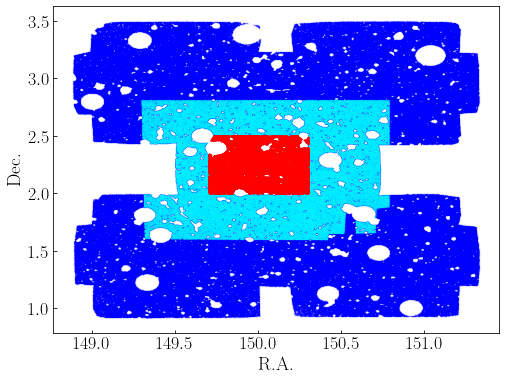

In [8]:
fig, axs = plt.subplots(1, 1, figsize = (8, 6),sharex=True, sharey=True)
cat_output_full_name = output_dir+'cat_out_15band_il.fits'
cat_output = Table.read(cat_output_full_name)

plt.scatter(cosmos_v9['RA'],cosmos_v9 ['DEC'],s=0.1,alpha=0.1,c='b')
plt.scatter(cosmos_v9[inside_j]['RA'],cosmos_v9[inside_j]['DEC'],s=0.1,alpha=0.1,c='cyan')
plt.scatter(cat_output['RA'],cat_output['DEC'],s=1,color='r')

plt.xlabel('R.A.',fontsize=19)
plt.ylabel('Dec.',fontsize=19)
plt.savefig('/Users/lejay/Desktop/smf_paper/sky_plot.png')


In [767]:
# based on ra/dec limit
d_ra = 151.9 - 148.3
dec_1 = 0.6
dec_2 = 4.0
area = 360**2*(d_ra*np.pi/180.)*(np.sin(dec_2*np.pi/180.)-np.sin(dec_1*np.pi/180.))/ (4*np.pi**2) # solid angle, in square degrees
print(d_ra*(dec_2-dec_1),area)
# masked area (estimate from random point catalog)
cat_random = Table.read('CUT_deep_catalogs/random_point_cat/COSMOS_deep_random_point.fits')
cat_random = cat_random[cat_random['RA'] > 148.3]
cat_random = cat_random[cat_random['RA'] < 151.9]
cat_random = cat_random[cat_random['DEC'] > 0.6]
cat_random = cat_random[cat_random['DEC'] < 4.0]
cat_random_nomask = cat_random[np.logical_and(cat_random['MASK']!=0, cat_random['inside']==0) ]
area = area * len(cat_random_nomask)/len(cat_random)
print(area)

# volume
total_soid_angle = 360**2/np.pi

12.23999999999998 12.22834501951379
4.406492756179495


In [706]:
# based on ra/dec limit
d_ra = 245. - 240.
dec_1 = 53.3
dec_2 = 56.9
area_elais = 360**2*(d_ra*np.pi/180.)*(np.sin(dec_2*np.pi/180.)-np.sin(dec_1*np.pi/180.))/ (4*np.pi**2) # solid angle, in square degrees
print(d_ra*(dec_2-dec_1),area_elais)

# masked area (estimate from random point catalog)
cat_random = Table.read('CUT_deep_catalogs/random_point_cat/ELAIS_deep_random_point.fits')
cat_random = cat_random[cat_random['RA'] > 240]
cat_random = cat_random[cat_random['RA'] < 245]
cat_random = cat_random[cat_random['DEC'] > 53.3]
cat_random = cat_random[cat_random['DEC'] < 56.9]
cat_random_nomask = cat_random[np.logical_and(cat_random['MASK']!=0, cat_random['inside']==0) ]
area_elais = area_elais * len(cat_random_nomask)/len(cat_random)
print(area_elais)

18.000000000000007 10.296931749586465
3.728927321927289


In [758]:
# based on ra/dec limit
d_ra = 354. - 350.3
dec_1 = -1.6
dec_2 = 1
area_deep = 360**2*(d_ra*np.pi/180.)*(np.sin(dec_2*np.pi/180.)-np.sin(dec_1*np.pi/180.))/ (4*np.pi**2) # solid angle, in square degrees
print(d_ra*(dec_2-dec_1),area_deep)

# masked area (estimate from random point catalog)
cat_random = Table.read('CUT_deep_catalogs/random_point_cat/DEEP_deep_random_point.fits')
cat_random = cat_random[cat_random['RA'] > 350.3]
cat_random = cat_random[cat_random['RA'] < 354]
cat_random = cat_random[cat_random['DEC'] > -1.6]
cat_random = cat_random[cat_random['DEC'] < 1]
cat_random_nomask = cat_random[np.logical_and(cat_random['MASK']!=0, cat_random['inside']==0) ]
area_deep = area_deep * len(cat_random_nomask)/len(cat_random)
print(area_deep)

9.61999999999997 9.619042762465472
3.7029813439273442


#### Thibaud's Stellar Mass Functions

In [48]:
# 0.2 - 0.5 
data_q1 = np.array([8.9170, -2.7438,
9.0377, -2.8086,
9.1584, -2.9081,
9.2867, -2.9816,
9.4049, -3.0508,
9.5256, -3.1027,
9.6513, -3.0984,
9.7695, -3.0854,
9.8927, -3.0422,
10.018, -2.9773,
10.139, -2.9341,
10.262, -2.9168,
10.383, -2.8692,
10.506, -2.8692,
10.627, -2.8605,
10.755, -2.9038,
10.873, -2.9946,
10.994, -3.0897,
11.120, -3.2800,
11.243, -3.4703,
11.364, -3.7946,
11.487, -4.1665,
11.605, -4.5081,
11.731, -4.9276,
11.839, -5.5330])
data_q1 = data_q1.reshape(len(data_q1)//2,2)

# 0.5 - 0.8
data_q2 = np.array([9.6745, -3.3924,
9.7626, -3.2670,
9.8557, -3.2368,
9.9463, -3.2022,
10.049, -3.1589,
10.135, -3.1157,
10.231, -3.0984,
10.319, -3.0595,
10.412, -3.0292,
10.508, -3.0032,
10.601, -3.0335,
10.701, -3.0119,
10.789, -3.0595,
10.883, -3.1027,
10.978, -3.1762,
11.066, -3.2800,
11.167, -3.4357,
11.268, -3.5870,
11.348, -3.7859,
11.439, -4.0584,
11.537, -4.3568,
11.615, -4.5989,
11.708, -5.2995,
11.801, -5.5114,
11.924, -6.0130])
data_q2 = data_q2.reshape(len(data_q2)//2,2)

# 0.8 - 1.1
data_q3 = np.array([10.116, -3.2757,
10.290, -3.2151,
10.476, -3.0465,
10.657, -2.9730,
10.836, -3.0292,
11.020, -3.2022,
11.199, -3.5049,
11.383, -3.9892,
11.567, -4.6551,
11.746, -5.4897])
data_q3 = data_q3.reshape(len(data_q3)//2,2)

# 1.1 - 1.5
data_q4 = np.array([10.354, -4.0195,
10.437, -3.8681,
10.545, -3.7600,
10.654, -3.7514,
10.759, -3.5654,
10.857, -3.5178,
10.956, -3.4962,
11.051, -3.5697,
11.172, -3.6908,
11.263, -3.8638,
11.371, -4.2141,
11.474, -4.5600,
11.577, -5.0486,
11.673, -5.4465,
11.781, -5.9438,
11.884, -6.0951])
data_q4 = data_q4.reshape(len(data_q4)//2,2)

data_q_list = [data_q1,data_q2,data_q3,data_q4]

In [47]:
# 0.2 - 0.5 
data_sf1 = np.array([8.7888, -1.9092,
8.9070, -1.9697,
9.0427, -1.9784,
9.1584, -2.0389,
9.2816, -2.0865,
9.3973, -2.1514,
9.5331, -2.2162,
9.6513, -2.2854,
9.7921, -2.3286,
9.9053, -2.3373,
10.023, -2.4108,
10.154, -2.4368,
10.275, -2.5059,
10.406, -2.5535,
10.519, -2.6443,
10.645, -2.7395,
10.758, -2.9038,
10.891, -3.0465,
11.009, -3.3189,
11.132, -3.5611,
11.261, -3.9373,
11.386, -4.3438,
11.502, -4.9405,
11.635, -5.9568])
data_sf1 = data_sf1.reshape(len(data_sf1)//2,2)
                   
# 0.5 - 0.8
data_sf2 = np.array([9.4857, -2.2292,
9.6871, -2.2811,
9.7978, -2.3373,
9.8935, -2.3978,
10.017, -2.4497,
10.128, -2.4973,
10.226, -2.5189,
10.341, -2.5578,
10.440, -2.5838,
10.550, -2.6530,
10.661, -2.7568,
10.762, -2.8519,
10.878, -2.9686,
10.983, -3.1589,
11.079, -3.3924,
11.197, -3.6822,
11.293, -4.0195,
11.421, -4.3395,
11.524, -4.8368,
11.628, -5.3946,
11.711, -6.0346,
11.985, -6.2249])
data_sf2 = data_sf2.reshape(len(data_sf2)//2,2)


# 0.8 - 1.1
data_sf3 = np.array([9.9622, -2.4843,
10.038, -2.4541,
10.108, -2.5103,
10.194, -2.5319,
10.262, -2.5665,
10.325, -2.5838,
10.406, -2.6141,
10.489, -2.6400,
10.549, -2.6573,
10.625, -2.7135,
10.713, -2.7697,
10.786, -2.8389,
10.864, -2.9168,
10.945, -3.0162,
11.005, -3.1416,
11.081, -3.2843,
11.146, -3.4616,
11.222, -3.7038,
11.297, -3.9416,
11.380, -4.2011,
11.456, -4.5903,
11.597, -5.3470,
11.748, -6.1038])
data_sf3 = data_sf3.reshape(len(data_sf3)//2,2)

# 1.1 - 1.5
data_sf4 = np.array([10.284, -2.7827,
10.321, -2.7611,
10.359, -2.7308,
10.399, -2.7178,
10.442, -2.7827,
10.497, -2.7957,
10.568, -2.8476,
10.648, -2.8822,
10.724, -2.9211,
10.789, -2.9643,
10.870, -3.0378,
10.945, -3.1200,
11.013, -3.2151,
11.081, -3.3319,
11.159, -3.4876,
11.230, -3.6562,
11.313, -3.8941,
11.383, -4.2097,
11.451, -4.4995,
11.527, -4.8368,
11.592, -5.0400,
11.663, -5.5459,
11.731, -6.2076])
data_sf4 = data_sf4.reshape(len(data_sf4)//2,2)

data_sf_list = [data_sf1,data_sf2,data_sf3,data_sf4]

In [885]:
# 0.2 - 0.5 
data_all1 = np.array([
8.806797853309481, -1.8715933625316152,
8.930232558139535, -1.9179487179487191,
9.059033989266547, -1.9275389139061962,
9.1824686940966, -1.9922850739210012,
9.305903398926654, -2.0386404293381046,
9.440071556350626, -2.1126148911233122,
9.56350626118068, -2.1681656488392664,
9.692307692307692, -2.205342051693296,
9.821109123434704, -2.260909259145026,
9.949910554561717, -2.2888902597002048,
10.07334525939177, -2.2984640059219057,
10.196779964221825, -2.3448193613390096,
10.330948121645797, -2.3728168116299644,
10.45438282647585, -2.419172167047068,
10.583184257602863, -2.483934776797649,
10.706618962432916, -2.5486809368124534,
10.835420393559929, -2.6778113626549884,
10.964221824686941, -2.852918799991776,
11.087656529516995, -3.0280097875927874,
11.216457960644007, -3.3042666502169316,
11.33989266547406, -3.617288672300702,
11.463327370304114, -4.05904632656838,
11.592128801431127, -4.390475602985628,
11.726296958855098, -4.951806386609915,
11.833631484794275, -5.476273312359921])
data_all1 = data_all1.reshape(len(data_all1)//2,2)

# 0.5 - 0.8
data_all2 = np.array([
9.648214285714285, -2.2390804597701157,
9.755357142857143, -2.275862068965518,
9.8625, -2.3034482758620696,
9.964285714285714, -2.3770114942528737,
10.066071428571428, -2.3862068965517245,
10.167857142857143, -2.3862068965517245,
10.275, -2.441379310344828,
10.382142857142856, -2.4505747126436788,
10.48392857142857, -2.4781609195402305,
10.591071428571428, -2.5149425287356326,
10.692857142857143, -2.570114942528736,
10.794642857142858, -2.6436781609195403,
10.907142857142857, -2.7540229885057474,
11.003571428571428, -2.8919540229885063,
11.110714285714284, -3.1034482758620694,
11.212499999999999, -3.3149425287356324,
11.319642857142856, -3.563218390804598,
11.42142857142857, -3.839080459770115,
11.528571428571428, -4.225287356321839,
11.625, -4.583908045977012,
11.732142857142858, -5.227586206896552,
11.8125, -5.586206896551724,
11.946428571428571, -5.816091954022988])
data_all2 = data_all2.reshape(len(data_all2)//2,2)

# 0.8 - 1.1
data_all3 = np.array([
10.051878354203936, -2.422988505747127,
10.223613595706619, -2.459770114942529,
10.395348837209301, -2.4781609195402297,
10.561717352415027, -2.496551724137931,
10.733452593917711, -2.5793103448275856,
10.91592128801431, -2.726436781609195,
11.103756708407872, -3.0022988505747126,
11.248658318425761, -3.44367816091954,
11.436493738819319, -4.0137931034482754,
11.613595706618963, -4.685057471264367,
11.774597495527729, -5.678160919540227])
data_all3 = data_all3.reshape(len(data_all3)//2,2)

# 1.1 - 1.5
data_all4 = np.array([
10.4030225352924, -2.724108278027165,
10.499401335577126, -2.7612707320986996,
10.569006875383167, -2.7891343435881195,
10.64933900041557, -2.8078143193946703,
10.740373023481634, -2.8357437633979465,
10.820680461321341, -2.8728568430840893,
10.906332676379707, -2.919202932838493,
10.986566052641326, -3.0116153241634143,
11.066799428902943, -3.1040277154883347,
11.15230352080513, -3.260972428520292,
11.237795269110974, -3.4271336934920456,
11.312474027016018, -3.6669944577252416,
11.39778062137664, -3.971404001793937,
11.483037841351871, -4.312679753621818,
11.568344435712493, -4.617089297690516,
11.648096411716542, -5.068947214667485,
11.72786073131694, -5.511588579704661,
11.818487415703522, -5.8436642377212085,
11.898757822754185, -5.908426973226742])
data_all4 = data_all4.reshape(len(data_all4)//2,2)

data_all_list = [data_all1,data_all2,data_all3,data_all4]

#### comoving cosmic volume
$H_0=69.6$ km/s/Mpc, $\Omega_M=0.286$

In [44]:
V2 = 2.336 # cosmic volume at z=0.2, Gpc^3
V5 = 29.127
V8 = 94.303
V11 = 194.160
V15 = 365.540

In [45]:
Va = (V5-V2)*area/total_soid_angle*10**9 # in Mpc^3
Vb = (V8-V5)*area/total_soid_angle*10**9 # in Mpc^3
Vc = (V11-V8)*area/total_soid_angle*10**9 # in Mpc^3
Vd = (V15-V11)*area/total_soid_angle*10**9 # in Mpc^3
cosmic_volumes = [Va,Vb,Vc,Vd]

In [43]:
def poisson_interval(k, a=0.3174): 
    lows = chi2.ppf(a/2, 2*k)/2
    highs = chi2.ppf(1-a/2, 2*k+2)/2 
    
    lows=np.array(lows)
    highs=np.array(highs)
    
    lows[np.isnan(lows)]=0
    return lows, highs

0.2


100%|██████████| 49/49 [00:03<00:00, 15.50it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWa

[10.513  6.89   1.031  1.947 -0.557  0.25 ]
[0.051 0.436 0.155 0.245 0.018 0.016]
0.5


100%|██████████| 49/49 [00:04<00:00, 10.75it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


[10.636  5.06   1.18   3.441 -0.342  0.2  ]
[0.137 0.953 0.323 0.614 0.018 0.071]
0.8


100%|██████████| 49/49 [00:07<00:00,  6.68it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


[10.69   4.978  0.88   1.647 -0.563  0.2  ]
[0.175 1.02  0.439 0.664 0.051 0.089]
1.1


100%|██████████| 49/49 [00:06<00:00,  7.28it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


[10.571  3.206  1.293  0.704 -0.808  0.2  ]
[0.097 0.125 0.346 0.258 0.074 0.039]


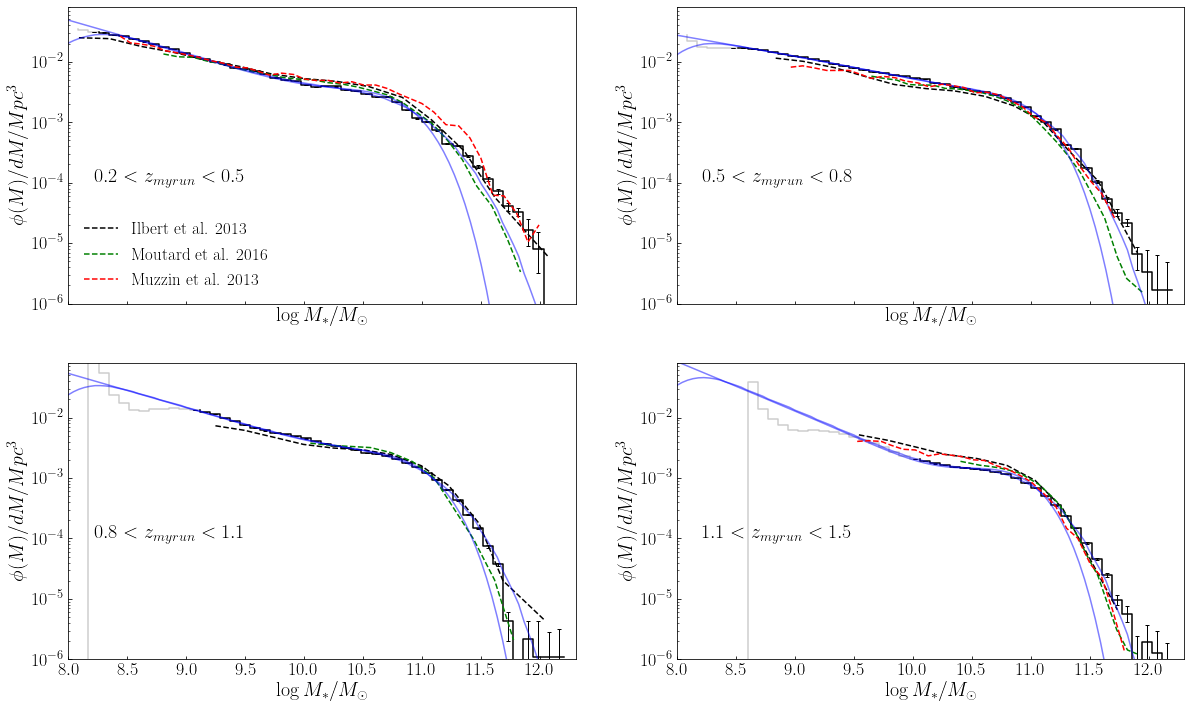

In [960]:


fig, axs = plt.subplots(2, 2, figsize = (20, 12),sharex=True)
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
mass_shift = [0.04, 0.05, 0.07, 0.08]
mass_comp_80 = [8.2, 8.5, 9.1, 10]
fit_start_shift = [2,2,0,-5]
end_point = [-3,-3,-6,-3]
sigma_ms = [0.25,0.2,0.2,0.2]
norms = [1,1,1,1]
num_bins = 50
cat_comp = Table.read('comp_sigmoid_params.fits')


fit_params = []
for i in range(len(z_mins)):
    print(z_mins[i])
    row = i//2
    col = i%2
    cat_z = cat[cat['Z_ML']>z_mins[i]]
    cat_z = cat_z[cat_z['Z_ML']<z_maxs[i]]
    cat_z = cat_z[cat_z['MASK'] == 0]  # unmasked
    cat_z = cat_z[cat_z['OBJ_TYPE'] == 0]  # galaxies
    cat_z['MASS_MED_massrun'] = cat_z['MASS_MED_massrun'] - mass_shift[i] # correction for masses
            
    # 1/vmax normalization
    bins = np.linspace(8,12.2,num_bins)
    bin_size = bins[1]-bins[0]
    inv_volumes = [] # sum of inverse of volumes
    for bin_num in tqdm(range(num_bins-1)):
        inv_volume = 0
        cat_massbin = cat_z[np.logical_and(cat_z['MASS_MED_massrun']>bins[bin_num], cat_z['MASS_MED_massrun']<bins[bin_num+1])]
        zmax_in_bin = p_sf[0]*bins[bin_num]**2 + p_sf[1]*bins[bin_num] + p_sf[2]
        if zmax_in_bin > z_maxs[i]:
            total_volume = ( cosmic_calc(z_maxs[i]) - cosmic_calc(z_mins[i]) )*1e9 # in Mpc^3
            inv_volume = len(cat_massbin) / (total_volume*area/total_soid_angle)
        else:
            max_gals_in_bin = 100
            if len(cat_massbin)> max_gals_in_bin:
                select_ids = np.random.choice(np.arange(len(cat_massbin)), size=max_gals_in_bin, replace=False)
                cat_select = cat_massbin[select_ids]
            else:
                cat_select = cat_massbin
                    
            for gal in cat_select:
                zmax = p_sf[0]*gal['MASS_MED_massrun']**2 + p_sf[1]*gal['MASS_MED_massrun'] + p_sf[2]
                total_volume = ( cosmic_calc(min(zmax,z_maxs[i])) - cosmic_calc(z_mins[i]) )*1e9 # in Mpc^3
                inv_volume += 1 / (total_volume*area/total_soid_angle) * len(cat_massbin) / len(cat_select)
                    
        inv_volumes.append(inv_volume)            
        
    # histograms (normalization and correction)
    sampling_factor = 1. #300000/1357601
    comp_param = cat_comp[i]
    # completeness = sigmoid(bins[:-1]+bin_size/2,comp_param[2],comp_param[3])
    completeness = np.ones(num_bins-1)
    weights = 1/bin_size/sampling_factor/completeness
    
    # data
    x = bins[:-1]+np.diff(bins)/2
    y = np.array(inv_volumes)*weights
    comp_limit_index = bisect(bins, mass_comp_80[i])
    axs[row][col].plot(bins[:comp_limit_index]+bin_size,y[:comp_limit_index],ls='steps',color='k',alpha=0.2)
    axs[row][col].plot(bins[comp_limit_index-1:-1]+bin_size,y[comp_limit_index-1:],ls='steps',color='k')
        
    # mass errorbars (randomly disturb the masses)
    mass_list = cat_z['MASS_MED_massrun']
    n,edges = np.histogram(mass_list,range=(8,12.2),bins=bins)
    hist_stack = []
    for k in range(20):
        mass_list_rand = mass_list + np.random.normal(0.2,size=len(mass_list))
        hist,bin_edges = np.histogram(mass_list_rand,bins=bins)
        hist_stack.append(hist)

    mass_errbar_minus = np.mean(np.array(hist_stack),axis=0) - np.percentile(np.array(hist_stack),16,axis=0)
    mass_errbar_plus = np.percentile(np.array(hist_stack),84,axis=0) - np.mean(np.array(hist_stack),axis=0)
    
    # poisson errorbars
    poisson_errbar_minus = n - poisson_interval(n, a=0.3174)[0]
    poisson_errbar_plus = poisson_interval(n, a=0.3174)[1] - n
        
    # total errorbars
    errbar_minus = mass_errbar_minus + poisson_errbar_minus
    errbar_plus = mass_errbar_plus + poisson_errbar_plus
    yerr = (errbar_minus*np.array(inv_volumes)/n + errbar_minus*np.array(inv_volumes)/n)/2
    yerr[np.isnan(yerr)]=1e-9
    log_yerr = (np.log10(y+yerr) - np.log10(y-yerr))/2
    axs[row][col].errorbar(bins[comp_limit_index-1:-1]+bin_size/2, np.array(inv_volumes)[comp_limit_index-1:]*weights[comp_limit_index-1:], yerr=np.array([errbar_minus[comp_limit_index-1:]*np.array(inv_volumes)[comp_limit_index-1:]/n[comp_limit_index-1:],errbar_plus[comp_limit_index-1:]*np.array(inv_volumes)[comp_limit_index-1:]/n[comp_limit_index-1:]]) , color='k',linewidth=1,capsize=2,linestyle='')
    
    # compare to ilbert+2013 results
    smf_il =  np.load('smf_il_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
    axs[row][col].plot(smf_il[:,0],10**smf_il[:,1],'--',color='k',label='Ilbert et al. 2013')
    
    # compare to moutard+2016 results
    axs[row][col].plot(data_all_list[i][:,0],10**data_all_list[i][:,1],'--g',label='Moutard et al. 2016')
    
    # save to disc
    smf_total = np.stack([x,y, errbar_minus*np.array(inv_volumes)/n, errbar_minus*np.array(inv_volumes)/n])
    np.save('smf_'+str(z_mins[i])+'_'+str(z_maxs[i]), smf_total)
    
    # schechter fit
    # popt, pcov, chi2_ = fit_schechter_con(x,y,yerr,comp_limit_index+fit_start_shift[i],-5,0.15)
    # print(popt)
    # print(np.sqrt(np.diag(pcov)))
    # x_plot = np.linspace(8,12.5,100)
    # axs[row][col].plot(x_plot,schechter(x_plot,popt[0] ,popt[1], popt[2]),color='b',alpha=0.5)
    # axs[row][col].plot(x_plot,con_schechter(x_plot, popt[0] ,popt[1], popt[2],0.15),color='b',alpha=0.5)
    
    # double schechter fit
    popt, pcov, chi2_ = fit_double_schechter_con(x,y*1e3,yerr,comp_limit_index+fit_start_shift[i],end_point[i],sigma_ms[i])
    print(popt)
    print(np.sqrt(np.diag(pcov)))
    fit_params.append(popt)
    x_plot = np.linspace(8,12.5,100)
    axs[row][col].plot(x_plot,double_schechter(x_plot,popt[0] ,popt[1]/1e3, popt[2],popt[3]/1e3, popt[4]),color='b',alpha=0.5)
    axs[row][col].plot(x_plot,con_double_schechter(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4],sigma_ms[i]),color='b',alpha=0.5)
    
    axs[row][col].set_xlabel('$\log M_*/M_\odot$',fontsize=20)
    axs[row][col].set_ylabel('$\phi(M)/dM/Mpc^3$',fontsize=20)
    axs[row][col].set_yscale('log')
    axs[row][col].set_xlim([8,12.3])
    axs[row][col].set_ylim([1e-6,8e-2])
    axs[row][col].annotate('$'+str(z_mins[i])+'<z_{myrun}<'+str(z_maxs[i])+'$',xy=([0.05,0.4]),xycoords='axes fraction',fontsize=20,color='k')

smf_mu =  np.load('smf_mu_0.2_0.5.npy')
axs[0][0].plot(smf_mu[:,0],10**smf_mu[:,1],'--',color='r',label='Muzzin et al. 2013')
smf_mu =  np.load('smf_mu_0.5_1.0.npy')
axs[0][1].plot(smf_mu[:,0],10**smf_mu[:,1],'--',color='r',label='Muzzin et al. 2013')

smf_mu =  np.load('smf_mu_1.0_1.5.npy')
axs[1][1].plot(smf_mu[:,0],10**smf_mu[:,1],'--',color='r',label='Muzzin et al. 2013')
axs[0][0].legend(fontsize=17,frameon=False)

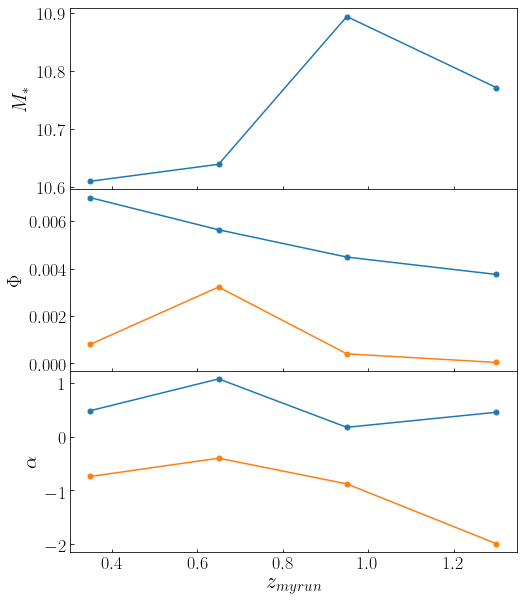

In [882]:
fig, axs = plt.subplots(3, 1, figsize = (8, 10),sharex=True)

phi1_list = []
phi2_list = []
alpha1_list = []
alpha2_list = []
ms_list = []

 # m_s,phi1,alpha_s1,phi2,alpha_s2,sigma_m
for i in range(4):
    phi1_list.append(max(fit_params[i][1],fit_params[i][3])/1e3)
    phi2_list.append(min(fit_params[i][1],fit_params[i][3])/1e3)
    alpha1_list.append(max(fit_params[i][2],fit_params[i][4]))
    alpha2_list.append(min(fit_params[i][2],fit_params[i][4]))
    ms_list.append(fit_params[i][0])
    
axs[0].plot((np.array(zmaxs)+np.array(zmins))/2,ms_list,'.-',markersize=10)
axs[1].plot((np.array(zmaxs)+np.array(zmins))/2,phi1_list,'.-',markersize=10)
axs[1].plot((np.array(zmaxs)+np.array(zmins))/2,phi2_list,'.-',markersize=10)
axs[2].plot((np.array(zmaxs)+np.array(zmins))/2,alpha1_list,'.-',markersize=10)
axs[2].plot((np.array(zmaxs)+np.array(zmins))/2,alpha2_list,'.-',markersize=10)

axs[2].set_xlabel(r'$z_{myrun}$',fontsize=22)
axs[0].set_ylabel(r'$M_*$',fontsize=20)
axs[1].set_ylabel(r'$\Phi$',fontsize=20)
axs[2].set_ylabel(r'$\alpha$',fontsize=21)
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)

0.2


100%|██████████| 49/49 [00:02<00:00, 23.06it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeW

0.5


100%|██████████| 49/49 [00:06<00:00,  7.04it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
100%|██████████| 49/49 [00:06<00:00,  7.93it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is de

0.8


100%|██████████| 49/49 [00:14<00:00,  3.48it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
100%|██████████| 49/49 [00:03<00:00, 13.74it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is de

1.1


100%|██████████| 49/49 [00:18<00:00,  2.60it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
100%|██████████| 49/49 [00:05<00:00,  9.76it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is de

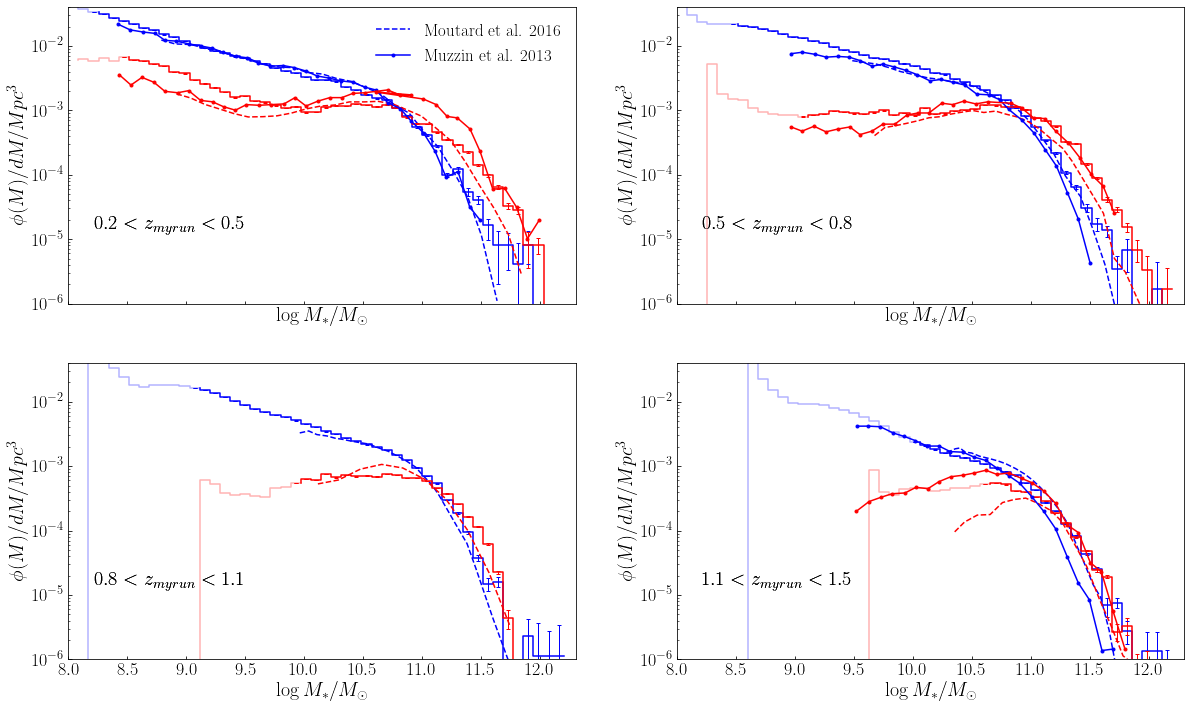

In [818]:
cat = Table.read(graham_output_dir+'COSMOS_deep_cat_out_nonir_il_22.4_formass_sfq_added.fits')
# cat = Table.read('/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_300k_nonir_il_formass_sfq_added.fits')
fig, axs = plt.subplots(2, 2, figsize = (20, 12),sharex=True)
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
mass_comp_sf_80_list = [8.2, 8.5, 9.1, 10.]
mass_comp_q_80_list = [8.5, 9.1, 9.9, 10.6]
mass_shift = [0.04, 0.05, 0.07, 0.08]
norms = [1,1,1,1]
num_bins = 50

cat_comp = Table.read('comp_sigmoid_params.fits')
for i in range(len(z_mins)):
    print(z_mins[i])
    row = i//2
    col = i%2
    cat_z = cat[cat['Z_ML']>z_mins[i]]
    cat_z = cat_z[cat_z['Z_ML']<z_maxs[i]]
    cat_z = cat_z[cat_z['MASK'] == 0]  # unmasked
    cat_z = cat_z[cat_z['OBJ_TYPE'] == 0]  # galaxies
    cat_z['MASS_MED_massrun'] = cat_z['MASS_MED_massrun'] - mass_shift[i]
    for k, sfq_type in enumerate(['sf','q']):
        if sfq_type == 'sf':
            cat_z_sfqtype = cat_z[cat_z['sfq_nuvrk_myrun']>0.5]
            color='b'
        else:
            cat_z_sfqtype= cat_z[cat_z['sfq_nuvrk_myrun']<0.5]
            color='r'
            
        # 1/vmax normalization
        bins = np.linspace(8,12.2,num_bins)
        bin_size = bins[1]-bins[0]
        inv_volumes = [] # sum of inverse of volumes
        for bin_num in tqdm(range(num_bins-1)):
            inv_volume = 0
            cat_massbin = cat_z_sfqtype[np.logical_and(cat_z_sfqtype['MASS_MED_massrun']>bins[bin_num], cat_z_sfqtype['MASS_MED_massrun']<bins[bin_num+1])]
            if sfq_type == 'sf':
                zmax_in_bin = p_sf[0]*bins[bin_num]**2 + p_sf[1]*bins[bin_num] + p_sf[2]
            else:
                zmax_in_bin = p_q[0]*bins[bin_num]**2 + p_q[1]*bins[bin_num] + p_q[2]
                
            if zmax_in_bin > z_maxs[i]:
                total_volume = ( cosmic_calc(z_maxs[i]) - cosmic_calc(z_mins[i]) )*1e9 # in Mpc^3
                inv_volume = len(cat_massbin) / (total_volume*area/total_soid_angle)
            else:
                max_gals_in_bin = 500
                if len(cat_massbin)> max_gals_in_bin:
                    select_ids = np.random.choice(np.arange(len(cat_massbin)), size=max_gals_in_bin, replace=False)
                    cat_select = cat_massbin[select_ids]
                else:
                    cat_select = cat_massbin
                    
                for gal in cat_select:
                    if sfq_type == 'sf':
                        zmax = p_sf[0]*gal['MASS_MED_massrun']**2 + p_sf[1]*gal['MASS_MED_massrun'] + p_sf[2]
                    else:
                        zmax = p_q[0]*gal['MASS_MED_massrun']**2 + p_q[1]*gal['MASS_MED_massrun'] + p_q[2]
                    total_volume = ( cosmic_calc(min(zmax,z_maxs[i])) - cosmic_calc(z_mins[i]) )*1e9 # in Mpc^3
                    inv_volume += 1 / (total_volume*area/total_soid_angle) * len(cat_massbin) / len(cat_select)
                    
            inv_volumes.append(inv_volume)            
        
        # histograms (normalization and correction)
        sampling_factor = 1. #300000/1357601
        comp_param = cat_comp[(k+1)*4+i]
        completeness = sigmoid(bins[:-1]+bin_size/2,comp_param[2],comp_param[3])
        weights = 1/bin_size/sampling_factor/completeness
        
        if sfq_type == 'sf':
            mass_comp = mass_comp_sf_80_list[i]
        else:
            mass_comp = mass_comp_q_80_list[i]
        comp_limit_index = bisect(bins,mass_comp )
        # axs[row][col].plot(bins[1:],np.array(inv_volumes)*weights,ls='steps',color=color)
        # axs[row][col].plot(bins[1:],np.array(inv_volumes)*weights,ls='steps',color=color)
        axs[row][col].plot(bins[:comp_limit_index]+bin_size,np.array(inv_volumes)[:comp_limit_index]*weights[:comp_limit_index],ls='steps',color=color,alpha=0.3)
        axs[row][col].plot(bins[comp_limit_index-1:-1]+bin_size,np.array(inv_volumes)[comp_limit_index-1:]*weights[comp_limit_index-1:],ls='steps',color=color)
        
        # mass errorbars (randomly disturb the masses)
        mass_list = cat_z_sfqtype['MASS_MED_massrun']
        n,edges = np.histogram(mass_list,range=(8,12.2),bins=bins)
        hist_stack = []
        for k in range(20):
            mass_list_rand = mass_list + np.random.normal(0.2,size=len(mass_list))
            hist,bin_edges = np.histogram(mass_list_rand,bins=bins)
            hist_stack.append(hist)

        mass_errbar_minus = np.mean(np.array(hist_stack),axis=0) - np.percentile(np.array(hist_stack),16,axis=0)
        mass_errbar_plus = np.percentile(np.array(hist_stack),84,axis=0) - np.mean(np.array(hist_stack),axis=0)
    
        # poisson errorbars
        poisson_errbar_minus = n - poisson_interval(n, a=0.3174)[0]
        poisson_errbar_plus = poisson_interval(n, a=0.3174)[1] - n
        
        # total errorbars
        errbar_minus = mass_errbar_minus + poisson_errbar_minus
        errbar_plus = mass_errbar_plus + poisson_errbar_plus
        axs[row][col].errorbar(bins[comp_limit_index-1:-1]+bin_size/2, np.array(inv_volumes)[comp_limit_index-1:]*weights[comp_limit_index-1:], yerr=np.array([errbar_minus[comp_limit_index-1:]*np.array(inv_volumes)[comp_limit_index-1:]/n[comp_limit_index-1:],errbar_plus[comp_limit_index-1:]*np.array(inv_volumes)[comp_limit_index-1:]/n[comp_limit_index-1:]]) , color=color,linewidth=1,capsize=2,linestyle='')
        
        # save to disc (for masses 80% completeness and up)
        smf_total = np.stack([np.array(inv_volumes)*weights, errbar_minus*np.array(inv_volumes)/n, errbar_plus*np.array(inv_volumes)/n])
        np.save( 'smf_'+sfq_type+'_'+str(z_mins[i])+'_'+str(z_maxs[i]), smf_total)
        
        # reference from Moutard et al. 2016
        if sfq_type =='q':
            axs[row][col].plot(data_q_list[i][:,0],10**data_q_list[i][:,1]*norms[i],'--r')
        else:
            axs[row][col].plot(data_sf_list[i][:,0],10**data_sf_list[i][:,1]*norms[i],'--b',label='Moutard et al. 2016')
    
        axs[row][col].set_xlabel('$\log M_*/M_\odot$',fontsize=20)
        axs[row][col].set_ylabel('$\phi(M)/dM/Mpc^3$',fontsize=20)
        axs[row][col].set_yscale('log')
        axs[row][col].set_xlim([8,12.3])
        axs[row][col].set_ylim([1e-6,4e-2])
        axs[row][col].annotate('$'+str(z_mins[i])+'<z_{myrun}<'+str(z_maxs[i])+'$',xy=([0.05,0.24]),xycoords='axes fraction',fontsize=20,color='k')

# Muzzin+2013
smf_mu =  np.load('smf_mu_sf_0.2_0.5.npy')
axs[0][0].plot(smf_mu[:,0],10**smf_mu[:,1],'.-',color='b',label='Muzzin et al. 2013')
smf_mu =  np.load('smf_mu_sf_0.5_1.0.npy')
axs[0][1].plot(smf_mu[:,0],10**smf_mu[:,1],'.-',color='b')
smf_mu =  np.load('smf_mu_sf_1.0_1.5.npy')
axs[1][1].plot(smf_mu[:,0],10**smf_mu[:,1],'.-',color='b')

smf_mu =  np.load('smf_mu_q_0.2_0.5.npy')
axs[0][0].plot(smf_mu[:,0],10**smf_mu[:,1],'.-',color='r')
smf_mu =  np.load('smf_mu_q_0.5_1.0.npy')
axs[0][1].plot(smf_mu[:,0],10**smf_mu[:,1],'.-',color='r')
smf_mu =  np.load('smf_mu_q_1.0_1.5.npy')
axs[1][1].plot(smf_mu[:,0],10**smf_mu[:,1],'.-',color='r')
axs[0][0].legend(fontsize=17,frameon=False)

# plt.savefig('/Users/lejay/Desktop/smf_paper/smf.png')
# plt.show()


#### schecter function fit

In [749]:
from scipy.optimize import curve_fit
from bisect import bisect

# schecter function
def schechter(log_m,phi,log_m_s,alpha_s):
    m_s = 10**(log_m_s-10)
    m = 10**(log_m-10)
    return phi*(m/m_s)**(alpha_s)*np.exp(-(m/m_s))

def double_schechter(log_m,log_m_s,phi1,alpha_s1,phi2,alpha_s2):
    m_s = 10**(log_m_s-10)
    m = 10**(log_m-10)
    return (phi1*(m/m_s)**(alpha_s1)+phi2*(m/m_s)**(alpha_s2))*np.exp(-(m/m_s))

def con_double_schechter(masses,m_s,phi1,alpha_s1,phi2,alpha_s2,sigma): # convolved schecter function with a gaussian function
    intervals = 300
    dx = (12.2-8)/intervals
    
    # the gaussian kernel
    kernel = []
    for i in range(int(-3*sigma/dx),int(3*sigma/dx)+1):
        kernel.append(gaussian(i*dx,0,sigma))
    kernel = np.array(kernel)
    kernel  = kernel / sum(kernel)
    
    # calculate convolved values
    con_values = []
    mrange = np.linspace(8, 12.2, intervals)
    values = double_schechter(mrange+dx/2,m_s,phi1,alpha_s1,phi2,alpha_s2)   
    if isinstance(masses, list) or isinstance(masses, np.ndarray):
        for m in masses:
            con_values.append(np.convolve(values,kernel,mode='same')[min(bisect(mrange, m),intervals-1)])
    else:
        m = masses 
        con_values = np.convolve(values, kernel, mode='same')[min(bisect(mrange, m),intervals-1)]           
    return np.array(con_values)

def con_schechter(masses,phi,m_s,alpha_s,sigma): # convolved schecter function with a gaussian function
    intervals = 300
    dx = (12.2-8)/intervals
    
    # the gaussian kernel
    kernel = []
    for i in range(int(-3*sigma/dx),int(3*sigma/dx)+1):
        kernel.append(gaussian(i*dx,0,sigma))
    kernel = np.array(kernel)
    kernel  = kernel / sum(kernel)
    
    # calculate convolved values
    con_values = []
    mrange = np.linspace(8, 12.2, intervals)
    values = schechter(mrange+dx/2,phi,m_s,alpha_s)   
    if isinstance(masses, list) or isinstance(masses, np.ndarray):
        for m in masses:
            con_values.append(np.convolve(values,kernel,mode='same')[min(bisect(mrange, m),intervals-1)])
    else:
        m = masses 
        con_values = np.convolve(values, kernel, mode='same')[min(bisect(mrange, m),intervals-1)]           
    return np.array(con_values)

def gaussian(x, mu, sig):
    return 1/(sig*np.sqrt(2*np.pi))*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


In [942]:
# fitting schecter function
def fit_schechter(xdata, ydata, ydata_err, start, end):
    popt,pcov = curve_fit(schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=[2e-4,2.2e+04,-1.75])
    res = ydata - schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_schechter_con(xdata, ydata, ydata_err, start, end, sigma_m):
    popt,pcov = curve_fit(con_schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=[2e-4,2.1e+01,-1.5,sigma_m],bounds=([0,1e3,-2,sigma_m-0.00000001],[1e-2,1e5,2,sigma_m]),method='trf',absolute_sigma=True)
    res = ydata - con_schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_double_schechter(xdata, ydata, ydata_err, start, end): # m_s,phi1,alpha_s1,phi2,alpha_s2,sigma_m
    popt,pcov = curve_fit(double_schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=[8,2e-1,-0.5,2e-1,-1.5],bounds=([0.1,0,-2,0,-2],[100,1e1,2,1e1,0]))
    res = ydata - double_schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_double_schechter_con(xdata, ydata, ydata_err, start, end, sigma_m): # log_m_s,phi1,alpha_s1,phi2,alpha_s2,sigma_m
    popt,pcov = curve_fit(con_double_schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=[11,2e-1,-0.5,2e-1,-1.5,sigma_m],bounds=([10,0,-2,0,-2,sigma_m-0.00001],[12,1e1,2,1e1,0,sigma_m]))
    res = ydata - con_double_schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

#### MCMC fit

In [460]:
# maximum likelihood
import emcee
from scipy.optimize import minimize

def log_prior_convolve(theta):
    phi,m_s,alpha_s,sigma = theta
    if 0 < phi < 1 and 0.0 < m_s < 2e4 and -5.0 < alpha_s < 0.0 and sigma>0:
        return 0.0
    return -np.inf

def log_likelihood_convolve(theta, x, y, yerr):
    phi,m_s,alpha_s,sigma = theta
    model = con_schechter(x, phi, m_s, alpha_s, sigma)
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability_convolve(theta, x, y, yerr):
    lp = log_prior_convolve(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_convolve(theta, x, y, yerr)

#################################################################
def log_prior(theta):
    phi,m_s,alpha_s = theta
    if 0 < phi < 1 and 0.0 < m_s < 2e4 and -5.0 < alpha_s < 0.0:
        return 0.0
    return -np.inf

def log_likelihood(theta, x, y, yerr):
    phi,m_s,alpha_s = theta
    model = schechter(x, phi, m_s, alpha_s)
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [462]:
def mcmc_fit_convolve(x, y, yerr, start=5, end=-5, chain_length=50000):
    x = x[start:end]
    y = y[start:end]
    yerr = yerr[start:end]
    nll = lambda *args: -log_likelihood_convolve(*args) # Negative Log-Likelihood
    initial = np.array([1e-3,2.2e+04,-0.75, 0.1])
    soln = minimize(nll, initial, args=(x, y, yerr),bounds=[(1e-6,1e-2),(1e3,1e5),(-2,0),(0.02,2)])
    
    pos = soln.x + np.array([0.5e-4,0.5e+04,0.5, 0.2])*np.random.randn(200, 4)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_convolve, args=(x, y, yerr))
    sampler.run_mcmc(pos, chain_length, progress=True)
    params = np.mean(sampler.get_chain(discard=100, thin=15, flat=True),axis=0)
    return sampler,soln.x,params

def mcmc_fit(x, y, yerr,start=5, end=-5, chain_length=50000):
    x = x[start:end]
    y = y[start:end]
    yerr = yerr[start:end]
    
    nll = lambda *args: -log_likelihood(*args) # Negative Log-Likelihood
    initial = np.array([1e-3,2.2e+04,-0.75])
    soln = minimize(nll, initial, args=(x, y, yerr),bounds=[(1e-6,1e-2),(1e3,1e5),(-2,2)])
    phi_ml,m_s_ml,alpha_s_ml = soln.x  # initial guess?
    
    pos = soln.x + 0.2*np.array([1e-4,1e+04,1])*np.random.randn(200, 3)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
    sampler.run_mcmc(pos, chain_length, progress=True)
    params = np.mean(sampler.get_chain(discard=200, thin=15, flat=True),axis=0)
    return sampler,soln.x,params


[ 4.034e-03  5.574e+03 -2.057e-01  2.000e-01]
[1.856e-04 2.718e+02 1.463e-02 1.915e-02]


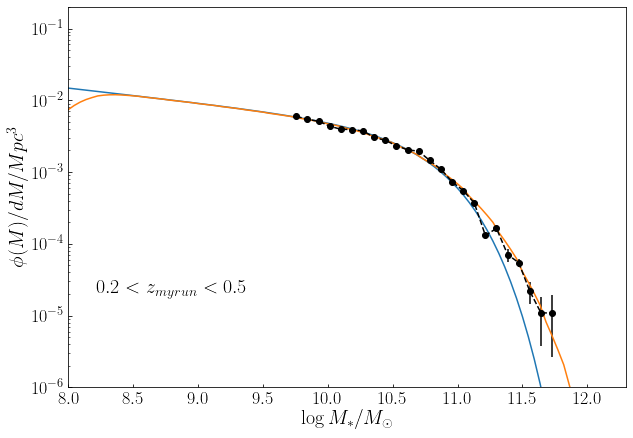

In [645]:
fig, axs = plt.subplots(1, 1, figsize = (10, 7),sharex=True)
smf = np.load('smf_sf_0.2_0.5.npy')
x = bins[:-1]+np.diff(bins)/2
y = smf[0]
yerr = (smf[1]+smf[2])/2
yerr[np.isnan(yerr)]=1e-9

x = x[20:-5]
y = y[20:-5]
yerr = yerr[20:-5]
plt.errorbar(x,y,yerr,fmt='ok--')

x_plot = np.linspace(8,12.5,100)
# sampler,solution,params = mcmc_fit(x,y,yerr,start=1,end=-1,chain_length=700)
# plt.plot(x_plot,schechter(x_plot,params[0],  params[1], params[2]))
# plt.plot(x_plot,con_schechter(x_plot, params[0],  params[1], params[2]))

# popt, pcov, chi2_ = fit_double_schechter_con(x,y,yerr,5,-4, 0.25)
# print(popt)
# plt.plot(x_plot,double_schechter(x_plot,popt[0] ,popt[1], popt[2],popt[3],popt[4]))
# plt.plot(x_plot,con_double_schechter(x_plot, popt[0] ,popt[1], popt[2],popt[3],popt[4], 0.25))

# popt, pcov, chi2_ = fit_schechter(x,y,yerr,1,-1)
popt, pcov, chi2_ = fit_schechter_con(x,y,yerr,1,-1,0.2)
print(popt)
print(np.sqrt(np.diag(pcov)))
plt.plot(x_plot,schechter(x_plot,popt[0] ,popt[1], popt[2]))
plt.plot(x_plot,con_schechter(x_plot, popt[0] ,popt[1], popt[2],0.2))

plt.xlabel('$\log M_*/M_\odot$',fontsize=20)
plt.ylabel('$\phi(M)/dM/Mpc^3$',fontsize=20)
plt.yscale('log')
plt.xlim([8,12.3])
plt.ylim([1e-6,2e-1])
plt.annotate('$0.2<z_{myrun}<0.5$',xy=([0.05,0.24]),xycoords='axes fraction',fontsize=20,color='k')
plt.show()

0.2
[ 7.664e+03  2.628e-03 -3.495e-01  1.300e-05 -1.257e+00  2.000e-01]
[1.379e+03 5.435e-04 7.949e-02 3.371e-05 3.620e-01 2.082e-02]


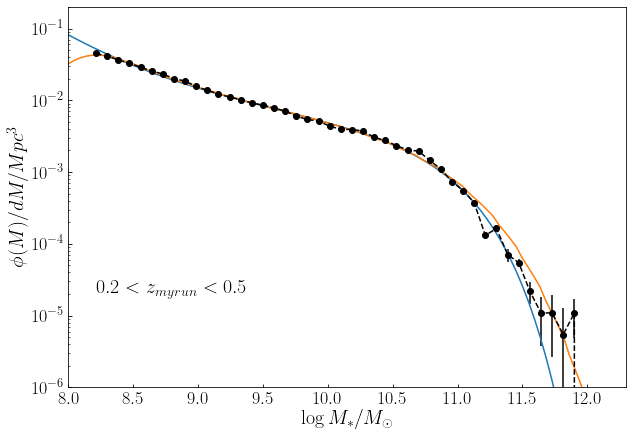

In [648]:
fig, axs = plt.subplots(1, 1, figsize = (10, 7),sharex=True)
smf = np.load('smf_sf_0.2_0.5.npy')
x = bins[:-1]+np.diff(bins)/2
y = smf[0]
yerr = (smf[1]+smf[2])/2
yerr[np.isnan(yerr)]=1e-9

x = x[2:-2]
y = y[2:-2]
yerr = yerr[2:-2]
plt.errorbar(x,y,yerr,fmt='ok--')

x_plot = np.linspace(8,12.5,100)

popt, pcov, chi2_ = fit_double_schechter_con(x,y,yerr,1,-1, 0.2)
print(popt)
print(np.sqrt(np.diag(pcov)))
plt.plot(x_plot,double_schechter(x_plot,popt[0] ,popt[1], popt[2],popt[3],popt[4]))
plt.plot(x_plot,con_double_schechter(x_plot, popt[0] ,popt[1], popt[2],popt[3],popt[4], 0.2))

plt.xlabel('$\log M_*/M_\odot$',fontsize=20)
plt.ylabel('$\phi(M)/dM/Mpc^3$',fontsize=20)
plt.yscale('log')
plt.xlim([8,12.3])
plt.ylim([1e-6,2e-1])
plt.annotate('$0.2<z_{myrun}<0.5$',xy=([0.05,0.24]),xycoords='axes fraction',fontsize=20,color='k')
plt.show()

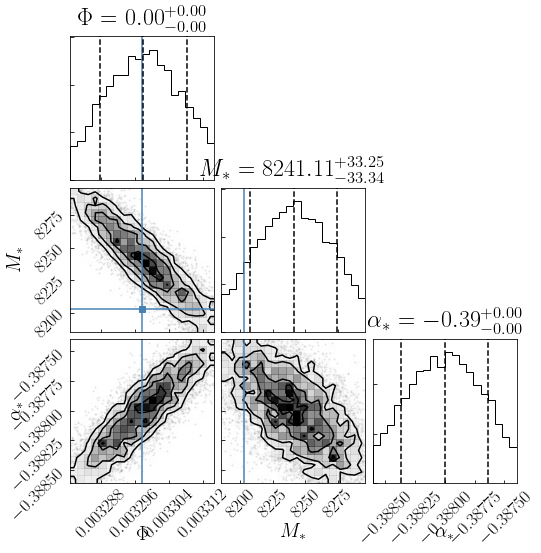

In [466]:
import corner
from matplotlib import rcParams
rcParams["font.size"] = 20
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

labels = [r"$\Phi$", r"$M_*$", r"$\alpha_*$"]
fig = corner.corner(
    flat_samples, labels=labels, truths=params,show_titles=True,quantiles=[.16,.50,.84],range=[0.90,0.90,0.90] 
);


#### MCMC with Thibaud's data

In [270]:
# maximum likelihood
import emcee
from scipy.optimize import minimize

# data
x = data_sf1[:,0]
y = 10**data_sf1[:,1]
yerr = 10**data_sf1[:,1]/50

params = mcmc_fit(x,y,yerr,chain_length=1000)
print(params)

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in square
  from ipykernel import kernelapp as app
/Users/lejay/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in square
  from ipykernel import kernelapp as app
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in true_divide
  from ipykernel import kernelapp as app
  0%|          | 0/1000 [00:00<?, ?it/

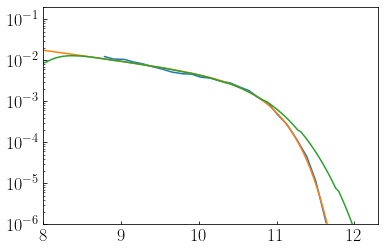

In [ ]:
x_plot = np.linspace(8,12,100)
plt.plot(x,y)
plt.plot(x_plot, schechter(x_plot),params[0],params[1],params[2])
plt.plot(x_plot, con_schechter(x_plot,params[0],params[1],params[2],0.25))
plt.xlim([8,12.3])
plt.ylim([1e-6,2e-1])
plt.yscale('log')

#### fitting with literature data

In [954]:
def double_schechter2(log_m,log_m_s,phi1,alpha_s1,phi2,alpha_s2):
    m_s = 10**(log_m_s-10)
    m = 10**(log_m-10)
    return np.log(10)*( phi1*(m/m_s)**(alpha_s1+1) + phi2*(m/m_s)**(alpha_s2+1) )*np.exp(-(m/m_s))

def fit_double_schechter2(xdata, ydata, ydata_err, start, end): # m_s,phi1,alpha_s1,phi2,alpha_s2
    popt,pcov = curve_fit(double_schechter2, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=[10.8,2e-3,-1,2e-4,-2],bounds=([10,0,-3,0,-3],[12,1e1,2,1e1,1]))
    res = ydata - double_schechter2(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

[ 1.100e+01  1.311e-03 -1.028e+00  4.545e-04 -1.467e+00]
[ 1.107e+01  1.711e-03 -1.172e+00  6.767e-06 -2.132e+00]
[ 1.097e+01  1.527e-03 -1.231e+00  4.330e-07 -2.602e+00]


Text(0.5, 1.0, 'Moutard et al., 2016')

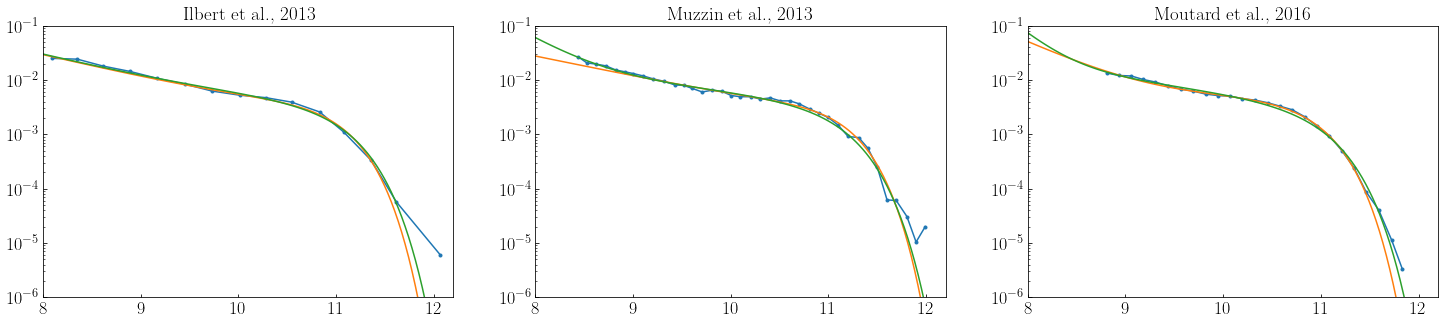

In [955]:
# double schechter, 0.2<z<0.5
fig, axs = plt.subplots(1, 3, figsize = (25, 5),sharex=True)
x_plot = np.linspace(8,12.2,120)

# double_schechter2(log_m,log_m_s,phi1,alpha_s1,phi2,alpha_s2)
# ilbert+2013 
smf_il =  np.load('smf_il_0.2_0.5.npy')
axs[0].plot(smf_il[:,0],10**smf_il[:,1],'.-')
axs[0].plot(x_plot,double_schechter2(x_plot, 10.88, 1.68e-3,-0.69,0.77e-3,-1.42))
popt,pcov,chi2_ = fit_double_schechter2(smf_il[:,0],10**smf_il[:,1],10**smf_il[:,1]/100,1,-1)
axs[0].plot(x_plot,double_schechter2(x_plot, popt[0], popt[1],popt[2],popt[3],popt[4]))
print(popt)
axs[0].set_yscale('log')
axs[0].set_xlim([8,12.2])
axs[0].set_ylim([1e-6,1e-1])
axs[0].set_ylim([1e-6,1e-1])
axs[0].set_title('Ilbert et al., 2013',fontsize=19)

# muzzin+2013 
smf_mu =  np.load('smf_mu_0.2_0.5.npy')
axs[1].plot(smf_mu[:,0],10**smf_mu[:,1],'.-')
axs[1].plot(x_plot,double_schechter2(x_plot, 10.97, 1.627e-3,-0.53,9.47e-4,-1.37))
popt,pcov,chi2_ = fit_double_schechter2(smf_mu[:,0],10**smf_mu[:,1],10**smf_mu[:,1]/100,1,-1)
print(popt)
axs[1].plot(x_plot,double_schechter2(x_plot, popt[0], popt[1],popt[2],popt[3],popt[4]))
axs[1].set_yscale('log')
axs[1].set_xlim([8,12.2])
axs[1].set_ylim([1e-6,1e-1])
axs[1].set_title('Muzzin et al., 2013',fontsize=19)

# moutard+2016
smf_tm = data_all1
axs[2].plot(smf_tm[:,0],10**smf_tm[:,1],'.-')
axs[2].plot(x_plot,double_schechter2(x_plot, 10.83, 10**(-2.63),-0.95,10**(-4.01),-1.82))
popt,pcov,chi2_ = fit_double_schechter2(smf_tm[:,0],10**smf_tm[:,1],10**smf_tm[:,1]/100,1,-1)
print(popt)
axs[2].plot(x_plot,double_schechter2(x_plot, popt[0], popt[1],popt[2],popt[3],popt[4]))
axs[2].set_yscale('log')
axs[2].set_xlim([8,12.2])
axs[2].set_ylim([1e-6,1e-1])
axs[2].set_title('Moutard et al., 2016',fontsize=19)

#### cosmic variance

#### COSMOS DEEP ELAIS

  4%|▍         | 2/49 [00:00<00:04, 10.25it/s]

1357601 308091.0545231585 107515 24399.223134821932


100%|██████████| 49/49 [00:02<00:00, 19.97it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  4%|▍         | 2/49 [00:00<00:04, 10.65it/s]

1090962 294617.2012962228 97964 26455.4397933046


100%|██████████| 49/49 [00:02<00:00, 22.50it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  4%|▍         | 2/49 [00:00<00:04, 11.65it/s]

1155513 309878.123181756 86939 23314.747779816138


100%|██████████| 49/49 [00:02<00:00, 23.42it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


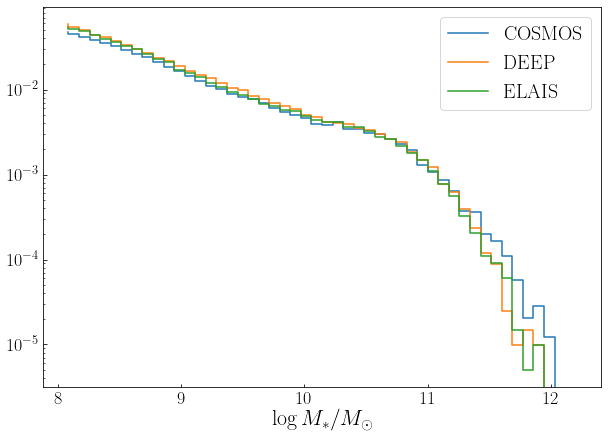

In [844]:
fig, axs = plt.subplots(1, 1, figsize = (10, 7),sharex=True)

areas = [area, area_deep,area_elais]
for i, cat_name in enumerate(['COSMOS_deep','DEEP_deep','ELAIS_deep']):
    cat = Table.read(graham_output_dir+cat_name+'_cat_out_nonir_il_22.4_formass.fits')
    cat_z = cat[cat['Z_ML']>0.2]
    cat_z = cat_z[cat_z['Z_ML']<0.5]
    cat_z = cat_z[cat_z['MASS_MED_massrun']>8]
    cat_z = cat_z[cat_z['MASS_MED_massrun']<12.2]
    cat_z = cat_z[cat_z['MASK'] == 0]  # unmasked
    cat_z = cat_z[cat_z['OBJ_TYPE'] == 0]  # galaxies
    print(len(cat),len(cat)/areas[i],len(cat_z),len(cat_z)/areas[i])
    
    # 1/vmax normalization
    bins = np.linspace(8,12.2,num_bins)
    bin_size = bins[1]-bins[0]
    inv_volumes = [] # sum of inverse of volumes
    for bin_num in tqdm(range(num_bins-1)):
        inv_volume = 0
        cat_massbin = cat_z[np.logical_and(cat_z['MASS_MED_massrun']>bins[bin_num], cat_z['MASS_MED_massrun']<bins[bin_num+1])]
        total_volume = ( cosmic_calc(0.5) - cosmic_calc(0.2))*1e9 # in Mpc^3
        inv_volume = len(cat_massbin) / (total_volume*areas[i]/total_soid_angle)
        inv_volumes.append(inv_volume)            
        
    # histograms (normalization and correction)
    sampling_factor = 1. #300000/1357601
    comp_param = cat_comp[i]
    completeness = sigmoid(bins[:-1]+bin_size/2,comp_param[2],comp_param[3])
    weights = 1/bin_size/sampling_factor/completeness
    
    # data
    x = bins[:-1]+np.diff(bins)/2
    y = np.array(inv_volumes)*weights
    plt.plot(bins[:-1]+bin_size,y,ls='steps',label=cat_name.replace('_deep',''))

plt.yscale('log')
plt.xlabel('$\log M_*/M_\odot$',fontsize=22)
plt.legend(fontsize=20)    

Text(0, 0.5, 'CDF')

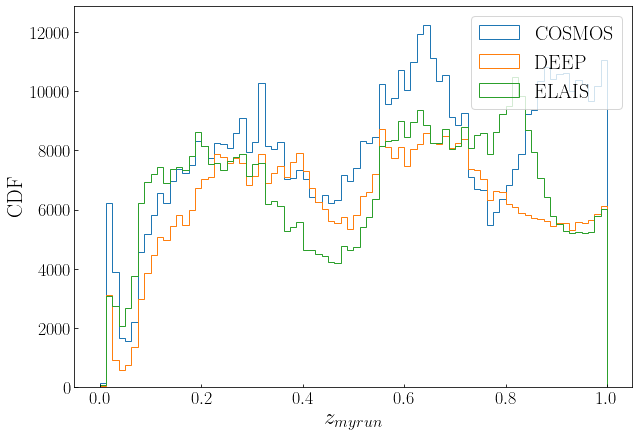

In [852]:
fig, axs = plt.subplots(1, 1, figsize = (10, 7),sharex=True)

for i, cat_name in enumerate(['COSMOS_deep','DEEP_deep','ELAIS_deep']):
    cat = Table.read(graham_output_dir+cat_name+'_cat_out_nonir_il_22.4_formass.fits')
    cat = cat[cat['Z_ML']<24.5]
    # hist, bin_edges = np.histogram(cat['Z_ML'],range=(0.0,0.5),bins=70, normed=True)
    # plt.plot((bin_edges[:-1]),np.cumsum(hist),label=cat_name.replace('_deep',''))
    plt.hist(cat['Z_ML'],range=(0.0,1.0),bins=80,histtype='step',label=cat_name.replace('_deep',''))

plt.legend(fontsize=20)
plt.xlabel('$z_{myrun}$',fontsize=23)
plt.ylabel('CDF',fontsize=21)

Text(0, 0.5, 'CDF')

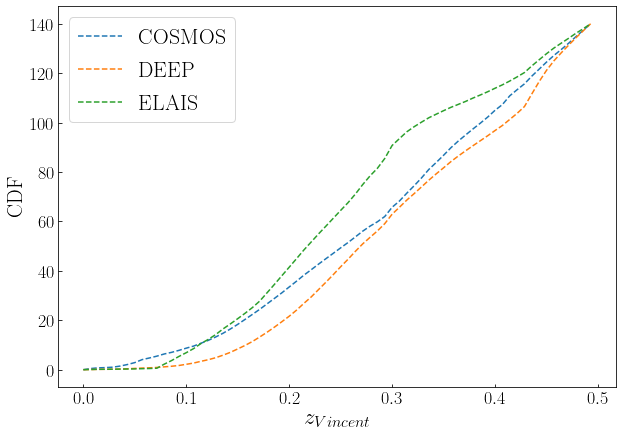

In [838]:
fig, axs = plt.subplots(1, 1, figsize = (10, 7),sharex=True)

for i, cat_name in enumerate(['COSMOS_deep','DEEP_deep','ELAIS_deep']):
    cat = Table.read(graham_output_dir+cat_name+'_cat_out_nonir_il_22.4_formass.fits')
    hist, bin_edges = np.histogram(cat['ZPHOT'],range=(0.0,0.5),bins=70, normed=True)
    plt.plot((bin_edges[:-1]),np.cumsum(hist),'--',label=cat_name.replace('_deep',''))

plt.legend(fontsize=22)
plt.xlabel('$z_{Vincent}$',fontsize=23)
plt.ylabel('CDF',fontsize=21)